In [1]:
##################################################
# Team: Michael Edukonis
#       Daniel Ip
#       Ananay Mathur
#       Canruo Zou
#
# class:CS445 Fa2023
# assignment:Final Project - Scene Text Detection
# date: 12/1/2023
##################################################

In [7]:
import os
import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import pytesseract
import math
from imutils.object_detection import non_max_suppression
import difflib
import json
from PIL import Image
import exifread

In [5]:
#==================================================================================================
# Function Name: log_photo_attributes(photo_directory, output_file)
# Input: 
#   - photo_directory (str): Path to the directory containing photos.
#   - output_file (str): File path where the output JSON will be saved.
# Output: None
# Function Operation: 
#   This function scans a specified directory for image files (supports .png, .jpg, .jpeg formats), 
#   gathers various attributes of each image, and logs these details into a JSON file. The function 
#   collects information such as filename, file size, image format, dimensions, color mode, and EXIF data.
#   It also calculates and prints statistics including total number of photos, sizes of the largest and 
#   smallest photos, and the average photo size.
#   The output is a JSON file containing a list of dictionaries, each representing a photo with its attributes.
# Note: 
#   - Requires the os, PIL.Image, exifread, and json libraries.
#   - The function assumes that the photo directory exists and contains image files.
#   - EXIF data extraction depends on the 'exifread' library.
#==================================================================================================
def log_photo_attributes(photo_directory, output_file):
    # List to hold photo attributes
    photo_attributes = []

    # Variables for statistics
    total_photos = 0
    total_size = 0
    largest_photo_size = 0
    smallest_photo_size = float('inf')
    largest_photo = ""
    smallest_photo = ""

    # Iterate through each file in the directory
    for filename in os.listdir(photo_directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(photo_directory, filename)

            # Dictionary to hold attributes of the current photo
            photo_info = {'filename': filename}

            # Get file size and update statistics
            file_size = os.path.getsize(file_path)
            photo_info['file_size'] = file_size
            total_photos += 1
            total_size += file_size
            if file_size > largest_photo_size:
                largest_photo_size = file_size
                largest_photo = filename
            if file_size < smallest_photo_size:
                smallest_photo_size = file_size
                smallest_photo = filename

            # Open the image and get basic attributes
            with Image.open(file_path) as img:
                photo_info['format'] = img.format
                photo_info['size'] = img.size
                photo_info['mode'] = img.mode

            # Extract EXIF data
            with open(file_path, 'rb') as f:
                tags = exifread.process_file(f, details=False)
                exif_data = {tag: str(tags[tag]) for tag in tags.keys() if tag not in ('JPEGThumbnail', 'TIFFThumbnail', 'Filename', 'EXIF MakerNote')}
                photo_info['exif'] = exif_data

            # Append the photo info to the list
            photo_attributes.append(photo_info)

    # Serialize the list of dictionaries to a JSON string
    json_data = json.dumps(photo_attributes, indent=4)

    # Write the JSON data to a file
    with open(output_file, 'w') as json_file:
        json_file.write(json_data)

    # Print the statistics
    print(f"Total number of photos: {total_photos}")
    print(f"Largest photo: {largest_photo} (Size: {largest_photo_size} bytes)")
    print(f"Smallest photo: {smallest_photo} (Size: {smallest_photo_size} bytes)")
    if total_photos > 0:
        avg_size = total_size / total_photos
        print(f"Average photo size: {avg_size:.2f} bytes")
    else:
        print("No photos found.")


log_photo_attributes('dataset', 'photo_attributes.json')

PNG file does not have exif data.


Total number of photos: 37
Largest photo: 16.jpg (Size: 544094 bytes)
Smallest photo: 11.jpg (Size: 14811 bytes)
Average photo size: 148582.51 bytes


In [1]:
#==================================================================================================
# Function Name: preprocess_image()
# Input: image (3-channel color image as a numpy array)
# Output: three_channel (preprocessed image as a 3-channel numpy array)
# Function Operation: This function preprocesses a given image for further processing or analysis. 
#                     It involves the following steps:
#                     1. Conversion to grayscale.
#                     2. Application of Gaussian blur to reduce noise and improve edge detection.
#                     3. Use of Otsu's thresholding for image binarization.
#                     4. Morphological operations (opening and closing) to refine the binary image.
#                     5. Conversion of the processed image back to a 3-channel format.
# Note: Requires the OpenCV library (imported as cv2) and numpy.
#==================================================================================================


def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Use Otsu's thresholding
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Perform morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Convert back to 3-channel image
    three_channel = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    return three_channel

In [2]:
#==================================================================================================
# Function Name: edge_detection()
# Input: image (3-channel color image as a numpy array)
# Output: three_channel_edges (edge-detected and dilated image as a 3-channel numpy array)
# Function Operation: This function performs edge detection and dilation on the given image. 
#                     The process involves the following steps:
#                     1. Conversion of the image to grayscale.
#                     2. Application of Gaussian blur to reduce noise and improve edge detection.
#                     3. Use of Canny edge detection to identify edges.
#                     4. Dilation of edges to make them more pronounced using a kernel.
#                     5. Conversion of the edge-detected and dilated image back to a 3-channel 
#                        format for compatibility with other processes, such as the EAST detector.
# Note: Requires the OpenCV library (imported as cv2) and numpy. The dilation step enhances the 
# visibility of edges.
#==================================================================================================



def edge_detection(image):

    #Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Apply Gaussian blur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    #Perform Canny edge detection
    edges = cv2.Canny(blurred, 240, 250)
    
    #Dilate the edges to make them more pronounced
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    
    #Convert the edges image to 3 channels so it can be processed by the EAST detector
    three_channel_edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return three_channel_edges

In [3]:
#==================================================================================================
# Function Name: extract_text()
# Input: 
#   - image (3-channel color image as a numpy array)
#   - rects (list of tuples defining bounding rectangles, each tuple contains startX, startY, endX, endY)
#   - display (boolean, optional): If True, displays the region of interest (ROI) for each rectangle.
#   - save (boolean, optional): If True, saves each ROI as an image file.
# Output: detected_texts (list of strings, each string contains text detected within a rectangle)
# Function Operation: 
#   This function extracts and recognizes text from specified regions in an image. The process involves:
#   1. Iterating over the given rectangles (rects) to extract each region of interest (ROI) from the image.
#   2. Optionally displaying each ROI for debug purposes (if display is True).
#   3. Optionally saving each ROI as an image file (if save is True).
#   4. Applying Optical Character Recognition (OCR) using Pytesseract on each ROI to extract text.
#   5. Collecting the recognized texts from all ROIs into a list.
#   6. Closing all display windows if display is True.
# Note: Requires the OpenCV library (imported as cv2), numpy, and Pytesseract.
#==================================================================================================

def extract_text(image, rects, display=False, save=False):
    detected_texts = []
    for idx, (startX, startY, endX, endY) in enumerate(rects):
        # Extract the region of interest
        roi = image[startY:endY, startX:endX]
        
        # Display the ROI for debug purposes
        if display:
            cv2.imshow(f"ROI {idx+1}", roi)
            cv2.waitKey(0)  # Wait for a key press to close the window

        # Save the ROI to disk
        if save:
            cv2.imwrite(f"roi_{idx+1}.jpg", roi)
        
        # OCR
        text = pytesseract.image_to_string(roi, lang='eng', config='--psm 6')
        detected_texts.append(text)

    if display:
        cv2.destroyAllWindows()

    return detected_texts

In [4]:
#==================================================================================================
# Function Name: compare_texts()
# Input: 
#   - detected_text (string): Text extracted from an image or any other source.
#   - ground_truth (string): Reference text for comparison.
# Output: A tuple containing three float values:
#   - token_match_ratio (float): Ratio of similarity between tokens (words) of the texts.
#   - word_match_ratio (float): Ratio of similarity between the texts considered as whole strings, 
#     case-insensitive.
#   - line_match_ratio (float): Ratio of similarity between the texts considering line structure, 
#     punctuation, and is case-sensitive.
# Function Operation: 
#   This function compares the extracted text (detected_text) with a reference or ground truth text 
#   (ground_truth) on three levels:
#   1. Token-Level: Splits the texts into tokens (words) and compares them for similarity.
#   2. Word-Level: Compares the complete texts as single strings, ignoring case differences.
#   3. Line-Level: Compares the texts considering line breaks, punctuation, and maintaining case sensitivity.
#   The function uses difflib.SequenceMatcher for calculating similarity ratios on these different levels.
# Note: Requires Python's standard library module difflib.
#==================================================================================================


def compare_texts(detected_text, ground_truth):
    # Convert both texts to lowercase for case-insensitive comparison
    detected_text_lower = detected_text.lower()
    ground_truth_lower = ground_truth.lower()

    # Token-Level Comparison
    detected_tokens = detected_text_lower.split()
    print("detected tokens: ", detected_tokens)
    ground_truth_tokens = ground_truth_lower.split()
    print("ground truth tokens: ", ground_truth_tokens)
    token_match_ratio = difflib.SequenceMatcher(None, detected_tokens, ground_truth_tokens).ratio()

    # Word-Level Comparison (as a whole string)
    word_match_ratio = difflib.SequenceMatcher(None, detected_text_lower, ground_truth_lower).ratio()

    # Line-Level Comparison (including punctuation and other characters, case sensitive)
    line_match_ratio = difflib.SequenceMatcher(None, detected_text, ground_truth).ratio()

    return token_match_ratio, word_match_ratio, line_match_ratio

In [5]:
#==================================================================================================
# Function Name: detect_text()
# Input: 
#   - image (3-channel color image as a numpy array)
#   - conf_threshold (float): Confidence threshold for text detection.
#   - padding (int): Padding to add around each detected text region.
# Output: 
#   - orig (numpy array): The original image with detected text regions highlighted.
#   - valid_rects (list of tuples): List of tuples representing the bounding boxes of detected 
#     text regions.
# Function Operation: 
#   This function detects text regions in an image using the EAST text detector model. 
#   The process involves:
#   1. Preparing the image by resizing it to a size compatible with the EAST model.
#   2. Loading the EAST model and running it on the image.
#   3. Processing the output from the model to extract potential text region coordinates.
#   4. Applying Non-Maximum Suppression to refine the bounding box detections.
#   5. Adjusting the coordinates of the bounding boxes based on original image size and applying padding.
#   6. Highlighting the detected text regions on the original image.
# Note: Requires OpenCV (imported as cv2), numpy, and the 'frozen_east_text_detection.pb' model file.
#==================================================================================================


def detect_text(image, conf_threshold, padding):
    valid_rects = []

    #image height and width should be multiple of 32
    imgWidth = 320
    imgHeight = 320

    orig = image.copy()
    (H, W) = image.shape[:2]
    (newW, newH) = (imgWidth, imgHeight)

    rW = W / float(newW)
    rH = H / float(newH)
    image = cv2.resize(image, (newW, newH))

    (H, W) = image.shape[:2]
    net = cv2.dnn.readNet("frozen_east_text_detection.pb")
    blob = cv2.dnn.blobFromImage(image, 1, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

    #Sigmoid - Probability scores 0-1 if area contains text
    #concat_3 - text geometry for the bounding box coordinates
    outputLayers = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
    net.setInput(blob)
    output = net.forward(outputLayers)
    scores = output[0]
    geometry = output[1]

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            if scoresData[x] < conf_threshold:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    #Apply Non-Maximum Suppression (NMS) to avoid overlapping bounding boxes
    indices = cv2.dnn.NMSBoxes(rects, confidences, conf_threshold, 0.4)

    #Handle both cases: indices as a list of lists or a one-dimensional array
    if len(indices) > 0 and isinstance(indices[0], list):
        indices = [i[0] for i in indices]

    for i in indices:
        (startX, startY, endX, endY) = rects[i]

        #Scale bounding box coordinates
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        #Apply padding with check to prevent coordinates from going negative
        startX = max(0, startX - padding)
        startY = max(0, startY - padding)
        endX = min(orig.shape[1], endX + padding)  #Ensure endX does not exceed image width
        endY = min(orig.shape[0], endY + padding)  #Ensure endY does not exceed image height

        #Store valid rectangles for later OCR
        valid_rects.append((startX, startY, endX, endY))

        #Draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    #return the image with the bounding boxes and a list of valid bounding boxes for OCR
    return orig, valid_rects


In [20]:
#Analyze Images
#This block of code will loop through all images in dataset directory, detect and extract text, save results 
#to a file for review in a new directory, output.  

#Create an output directory if it doesn't exist
output_dir = "output/"
all_texts_output_path = f"{output_dir}detected_texts.txt"
confidence_threshold = 0.9
padding = 0
total_processing_time = 0
num_images_processed = 0
longest_time = 0
shortest_time = float('inf')
longest_time_image = 0
shortest_time_image = 0
processing_times = []

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#Open the file for writing outside the loop
with open(all_texts_output_path, 'w') as all_texts_file:
    for i in range(1, 38):  # Looping from 1.jpg to 37.jpg
        start_time = time.time()  #Start the timer
        image_path = f"dataset/{i}.jpg"
        test_image = cv2.imread(image_path)

        if test_image is not None:
            #optional pre-processing steps
            test_image = edge_detection(test_image)
            
            #Run the text detection
            im_out, rects = detect_text(test_image, confidence_threshold, padding)

            #Extract text
            detected_texts = extract_text(im_out, rects)

            #Save the output image with bounding boxes
            output_path = f"{output_dir}{i}_boxed.jpg"
            cv2.imwrite(output_path, im_out)

            #Write the detected texts to the common file, each on a new line
            cleaned_text = ','.join([text.replace('\n', ' ').strip() for text in detected_texts])
            all_texts_file.write(cleaned_text + "\n")
            
            #Calculate and print the time taken for the current image
            processing_time = time.time() - start_time
            print(f"Processing time for image {i}: {processing_time:.2f} seconds")

            #Add the time taken for the current image to the total processing time
            total_processing_time += processing_time
            processing_times.append(processing_time)  #Store the processing time
            num_images_processed += 1
            
            # Check and update longest and shortest processing times
            if processing_time > longest_time:
                longest_time = processing_time
                longest_time_image = i
            if processing_time < shortest_time:
                shortest_time = processing_time
                shortest_time_image = i

        else:
            print(f"Image {i} not found or unable to read.")
            processing_times.append(0)

#Calculate and print the average processing time
if num_images_processed > 0:
    avg_processing_time = total_processing_time / num_images_processed
    print(f"\nAverage processing time for each image: {avg_processing_time:.2f} seconds")
    print(f"Longest processing time: {longest_time:.2f} seconds (Image {longest_time_image})")
    print(f"Shortest processing time: {shortest_time:.2f} seconds (Image {shortest_time_image})")
else:
    print("No images were processed.")
            
#Print the total processing time
print(f"\nTotal processing time for all images: {total_processing_time:.2f} seconds")


Processing time for image 1: 0.39 seconds
Processing time for image 2: 0.41 seconds
Processing time for image 3: 0.70 seconds
Processing time for image 4: 0.56 seconds
Processing time for image 5: 0.53 seconds
Processing time for image 6: 0.54 seconds
Processing time for image 7: 0.69 seconds
Processing time for image 8: 0.46 seconds
Processing time for image 9: 0.61 seconds
Processing time for image 10: 0.39 seconds
Processing time for image 11: 0.62 seconds
Processing time for image 12: 0.73 seconds
Processing time for image 13: 0.47 seconds
Processing time for image 14: 0.55 seconds
Processing time for image 15: 0.37 seconds
Processing time for image 16: 0.42 seconds
Processing time for image 17: 0.55 seconds
Processing time for image 18: 0.45 seconds
Processing time for image 19: 0.45 seconds
Processing time for image 20: 0.63 seconds
Processing time for image 21: 0.48 seconds
Processing time for image 22: 0.41 seconds
Processing time for image 23: 0.38 seconds
Processing time for 

Text(0.5, 0, 'Process Time')

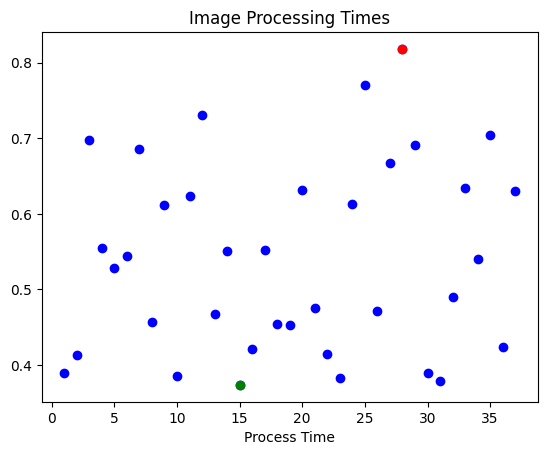

In [21]:
#scatter plot of processing times
#Image numbers
image_numbers = np.array(range(1, 38))  # Assuming 37 images

#Convert processing_times to a numpy array
processing_times = np.array(processing_times)

#Find the images with the longest and shortest processing times
max_time_idx = np.argmax(processing_times)
min_time_idx = np.argmin(processing_times)

#Create the scatter plot
plt.scatter(image_numbers, processing_times, color='blue', label='Processing Times')

#Highlight the longest and shortest processing times
plt.scatter(image_numbers[max_time_idx], processing_times[max_time_idx], color='red', label='Longest Time')
plt.scatter(image_numbers[min_time_idx], processing_times[min_time_idx], color='green', label='Shortest Time')

#Labeling the plot
plt.title('Image Processing Times')
plt.xlabel('Image Number')
plt.xlabel('Process Time')

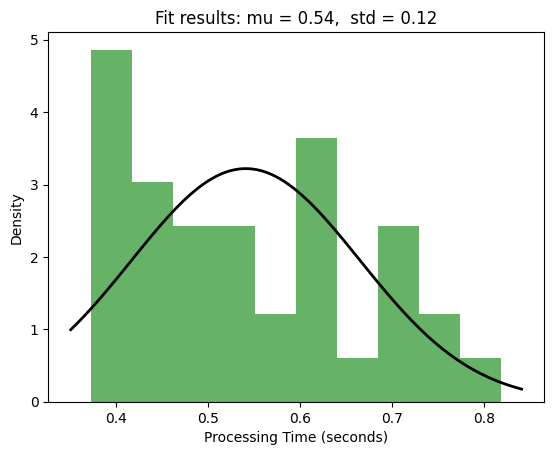

In [22]:
#plot normal distribution of processing times
from scipy.stats import norm
# Fit a normal distribution to the data
mu, std = norm.fit(processing_times)

# Plot the histogram
plt.hist(processing_times, bins=10, density=True, alpha=0.6, color='g')

# Plot the PDF (Probability Density Function)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = {:.2f},  std = {:.2f}".format(mu, std)
plt.title(title)
plt.xlabel('Processing Time (seconds)')
plt.ylabel('Density')

plt.show()

In [23]:
#compare detected text against known 'ground truth' in each image
#Read in the text files.  detected_texts.txt is generated by the program.  ground_truths.txt is compiled 
#manually  by the team for comparison purposes. 

with open('ground_truths.txt', 'r') as file:
    ground_truths = [line.strip() for line in file]

with open('output/detected_texts.txt', 'r') as file:
    detected_texts = [line.strip() for line in file]


In [24]:
#This block of code is designed to compute and display the average similarity ratios between detected 
#text and ground truth text.  It initializes variables to 
#accumulate total ratios for token match, word match, and line match, as well as a count of the number 
#of lines processed. It then iterates over pairs of ground truth and detected text lines, using the 
#compare_texts function to calculate similarity ratios for each pair. These ratios are then added to 
#the respective totals and the number of processed lines is incremented. After processing all lines, 
#it calculates the average ratios by dividing the total ratios by the number of lines, provided that 
#there are lines to compare. Finally, it prints out these average ratios and what photos had the
#highest and lowest scores of each category.

#Initialize sums for average calculation and variables for tracking extremes
total_token_ratio = 0
total_word_ratio = 0
total_line_ratio = 0
num_lines = 0

#Initialize variables for tracking highest and lowest ratios
lowest_token_ratio = float('inf')
highest_token_ratio = 0
lowest_word_ratio = float('inf')
highest_word_ratio = 0
lowest_line_ratio = float('inf')
highest_line_ratio = 0

#Variables to track file names (photos) with highest and lowest ratios
file_lowest_token = ""
file_highest_token = ""
file_lowest_word = ""
file_highest_word = ""
file_lowest_line = ""
file_highest_line = ""

#Loop through each line and calculate the ratios
for i, (ground_truth, detected_text) in enumerate(zip(ground_truths, detected_texts)):
    token_ratio, word_ratio, line_ratio = compare_texts(detected_text, ground_truth)
    print(f"Photo {i + 1} - Token Match Ratio: {token_ratio:.2f}, Word Match Ratio: {word_ratio:.2f}, Line Match Ratio: {line_ratio:.2f}\n")

    #Update total ratios
    total_token_ratio += token_ratio
    total_word_ratio += word_ratio
    total_line_ratio += line_ratio

    #Check and update highest and lowest ratios and corresponding files
    if token_ratio < lowest_token_ratio:
        lowest_token_ratio = token_ratio
        file_lowest_token = f"Photo {i + 1}"
    if token_ratio > highest_token_ratio:
        highest_token_ratio = token_ratio
        file_highest_token = f"Photo {i + 1}"

    if word_ratio < lowest_word_ratio:
        lowest_word_ratio = word_ratio
        file_lowest_word = f"Photo {i + 1}"
    if word_ratio > highest_word_ratio:
        highest_word_ratio = word_ratio
        file_highest_word = f"Photo {i + 1}"

    if line_ratio < lowest_line_ratio:
        lowest_line_ratio = line_ratio
        file_lowest_line = f"Photo {i + 1}"
    if line_ratio > highest_line_ratio:
        highest_line_ratio = line_ratio
        file_highest_line = f"Photo {i + 1}"

    num_lines += 1

# Calculate averages and print highest/lowest ratios with corresponding files
if num_lines > 0:
    avg_token_ratio = total_token_ratio / num_lines
    avg_word_ratio = total_word_ratio / num_lines
    avg_line_ratio = total_line_ratio / num_lines

    print(f"\nAverage Token Match Ratio: {avg_token_ratio:.2f}")
    print(f"Average Word Match Ratio: {avg_word_ratio:.2f}")
    print(f"Average Line Match Ratio: {avg_line_ratio:.2f}")

    print(f"\nHighest Token Match Ratio: {highest_token_ratio:.2f} ({file_highest_token})")
    print(f"Lowest Token Match Ratio: {lowest_token_ratio:.2f} ({file_lowest_token})")
    print(f"Highest Word Match Ratio: {highest_word_ratio:.2f} ({file_highest_word})")
    print(f"Lowest Word Match Ratio: {lowest_word_ratio:.2f} ({file_lowest_word})")
    print(f"Highest Line Match Ratio: {highest_line_ratio:.2f} ({file_highest_line})")
    print(f"Lowest Line Match Ratio: {lowest_line_ratio:.2f} ({file_lowest_line})")
else:
    print("No lines to compare.")


detected tokens:  []
ground truth tokens:  ['twins']
Photo 1 - Token Match Ratio: 0.00, Word Match Ratio: 0.00, Line Match Ratio: 0.00

detected tokens:  []
ground truth tokens:  ['oakley']
Photo 2 - Token Match Ratio: 0.00, Word Match Ratio: 0.00, Line Match Ratio: 0.00

detected tokens:  [',ene,14,,']
ground truth tokens:  ['golden', 'tree']
Photo 3 - Token Match Ratio: 0.00, Word Match Ratio: 0.30, Line Match Ratio: 0.30

detected tokens:  [',painidiigri', 'nan']
ground truth tokens:  ['monokraft', 'handicraft']
Photo 4 - Token Match Ratio: 0.00, Word Match Ratio: 0.33, Line Match Ratio: 0.17

detected tokens:  [',']
ground truth tokens:  ['call', 'for', 'paper']
Photo 5 - Token Match Ratio: 0.00, Word Match Ratio: 0.00, Line Match Ratio: 0.00

detected tokens:  ['mee,']
ground truth tokens:  ['california', '3sam123']
Photo 6 - Token Match Ratio: 0.00, Word Match Ratio: 0.09, Line Match Ratio: 0.00

detected tokens:  [',sst', 'ilo', '22,snore,']
ground truth tokens:  ['the', 'north'